In [1]:
import json
from collections import defaultdict
import numpy as np
from os import listdir
import matplotlib.pyplot as plt
import scipy.stats as stats
import gzip
import scipy.sparse as sparse

from matplotlib.patches import Rectangle


In [2]:
#family_id = '11002'
#family_id = '11089'
ped_file = '../../DATA/ssc/ssc.ped'
chroms = [str(x) for x in range(1, 23)]

In [3]:
colors=['#ef6c00', '#4db6ac']

In [4]:
ssc_old_id_to_new_id = dict()
with open('../data/ssc.id_map.from.repository', 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        ssc_old_id_to_new_id[pieces[1]] = pieces[0]
        ssc_old_id_to_new_id[pieces[1].replace('.', '_')] = pieces[0]

In [5]:
# pull affected status
# (0=unknown; 1=unaffected; 2=affected)
child_id_to_affected = dict()
child_id_to_sex = dict()
fam_to_inds = dict()
with open(ped_file, 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        if len(pieces) >= 6:
            fam_id, child_id, f_id, m_id, sex, disease_status = pieces[0:6]
            if child_id in ssc_old_id_to_new_id and m_id in ssc_old_id_to_new_id and f_id in ssc_old_id_to_new_id:
                child_id = ssc_old_id_to_new_id[child_id]
                f_id = ssc_old_id_to_new_id[f_id]
                m_id = ssc_old_id_to_new_id[m_id]
                child_id_to_affected[child_id] = disease_status
                child_id_to_sex[child_id] = sex

                if (fam_id, m_id, f_id) not in fam_to_inds:
                    fam_to_inds[(fam_id, m_id, f_id)] = [m_id, f_id]
                fam_to_inds[(fam_id, m_id, f_id)].append(child_id)
                
print('ped loaded')
print('children', len(child_id_to_affected))

ped loaded
children 1037


# pull our deletions

In [9]:
# pull deletions
deletions = []
with open('../phased_ssc_del/deletions.json') as f:
    for d in json.load(f):
        if d['is_inherited']:
            for child in d['trans']:
                if '%s_num_markers_aCGH' % ssc_old_id_to_new_id.get(child, child) in d:
                    deletions.append({
                                'family': d['family'],
                                'child': ssc_old_id_to_new_id[child],
                                'chrom': d['chrom'],
                                'start_pos': d['start_pos'],
                                'end_pos': d['end_pos'],
                                'length': d['length'],
                                'opt_start_pos': d['opt_start_pos'],
                                'opt_end_pos': d['opt_end_pos'],
                                'is_mat': d['is_mat'],
                                'is_pat': d['is_pat'],
                                'mother': ssc_old_id_to_new_id[d['mother']],
                                'father': ssc_old_id_to_new_id[d['father']],
                                'is_inherited': d['is_inherited'],
                                'is_denovo': d['is_denovo'],
                                'num_markers': d['num_markers'],
                                'num_markers_aCGH': d['%s_num_markers_aCGH' % ssc_old_id_to_new_id.get(child, child)],
                                'med_aCGH': d['%s_med_aCGH' % ssc_old_id_to_new_id.get(child, child)]
                        })
print(len(deletions))

2490


# pull sebat deletions

In [70]:
# pull deletions
sebat_deletions = []
with open('../phased_ssc.sebat_del/deletions.json') as f:
    for d in json.load(f):
        if d['is_inherited']:
            for child in d['trans']:
                if '%s_num_markers_aCGH' % ssc_old_id_to_new_id.get(child, child) in d:
                    sebat_deletions.append({
                                'family': d['family'],
                                'child': child,
                                'chrom': d['chrom'],
                                'start_pos': d['start_pos'],
                                'end_pos': d['end_pos'],
                                'length': d['length'],
                                'opt_start_pos': d['opt_start_pos'],
                                'opt_end_pos': d['opt_end_pos'],
                                'is_mat': d['is_mat'],
                                'is_pat': d['is_pat'],
                                'mother': d['mother'],
                                'father': d['father'],
                                'is_inherited': d['is_inherited'],
                                'is_denovo': d['is_denovo'],
                                'num_markers_ssc': d['num_markers_ssc'],
                                'num_markers_aCGH': d['%s_num_markers_aCGH' % ssc_old_id_to_new_id.get(child, child)],
                                'med_aCGH': d['%s_med_aCGH' % ssc_old_id_to_new_id.get(child, child)]
                        })
print(len(sebat_deletions))

24673


In [71]:
#remove deletions that aren't inherited
deletions = [d for d in deletions if d['is_inherited']]
print('remaining deletions', len(deletions))

sebat_deletions = [d for d in sebat_deletions if d['is_inherited']]
print('remaining deletions', len(sebat_deletions))

remaining deletions 1185
remaining deletions 24673


In [72]:
#remove deletions <100bp
deletions = [d for d in deletions if d['length']>=100]
print('remaining deletions', len(deletions))

sebat_deletions = [d for d in sebat_deletions if d['length']>=100]
print('remaining deletions', len(sebat_deletions))

remaining deletions 1185
remaining deletions 24673


In [73]:
chrom_to_interval_starts, chrom_to_interval_ends = defaultdict(list), defaultdict(list)
with open('../data/filtered_regions_hg19.bed', 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        if pieces[0][3:] in chroms:
            chrom_to_interval_starts[pieces[0][3:]].append(int(pieces[1]))
            chrom_to_interval_ends[pieces[0][3:]].append(int(pieces[2]))
            
for chrom in [str(x) for x in range(1, 23)]:
    chrom_to_interval_starts[chrom] = np.array(chrom_to_interval_starts[chrom])
    chrom_to_interval_ends[chrom] = np.array(chrom_to_interval_ends[chrom])
         
excluded_deletions = set()
for i, d in enumerate(deletions):
    starts, ends = chrom_to_interval_starts[d['chrom']], chrom_to_interval_ends[d['chrom']]
    overlaps = np.clip(np.minimum(d['end_pos'], ends) - np.maximum(d['start_pos'], starts), 0, None)
    if np.sum(overlaps)/d['length'] > 0.66:
        excluded_deletions.add(i)
print('excluded deletions', len(excluded_deletions)) 
deletions = [d for i, d in enumerate(deletions) if i not in excluded_deletions]
print('remaining deletions', len(deletions))

excluded_deletions = set()
for i, d in enumerate(sebat_deletions):
    starts, ends = chrom_to_interval_starts[d['chrom']], chrom_to_interval_ends[d['chrom']]
    overlaps = np.clip(np.minimum(d['end_pos'], ends) - np.maximum(d['start_pos'], starts), 0, None)
    if np.sum(overlaps)/d['length'] > 0.66:
        excluded_deletions.add(i)
print('excluded deletions', len(excluded_deletions)) 
sebat_deletions = [d for i, d in enumerate(sebat_deletions) if i not in excluded_deletions]
print('remaining deletions', len(sebat_deletions))

excluded deletions 0
remaining deletions 1185
excluded deletions 830
remaining deletions 23843


# compare

In [74]:

chrom_fam_to_dels = defaultdict(list)
for i, d in enumerate(deletions):
    chrom_fam_to_dels[(d['family'], d['chrom'])].append((i, d))
sebat_chrom_fam_to_dels = defaultdict(list)
for i, d in enumerate(sebat_deletions):
    sebat_chrom_fam_to_dels[(d['family'], d['chrom'])].append((i, d))

del_to_overlaps = defaultdict(list)
sebat_del_to_overlaps = defaultdict(list)
for (fam, chrom), ds in chrom_fam_to_dels.items():
    sds = sebat_chrom_fam_to_dels[(fam, chrom)]

    for i, d in ds:
        d_start, d_end = d['start_pos'], d['end_pos']
        for j, sb in sds:
            if (d['chrom']==sb['chrom']) and (d['child']==sb['child']):
                overlap = min(d_end, sb['end_pos']) - max(d_start, sb['start_pos']) 

                if overlap>0:
                    del_to_overlaps[i].append(j)
                    sebat_del_to_overlaps[j].append(i)


        
        

In [75]:
is_val = np.zeros((len(deletions),), dtype=bool)
for del_index, overlap_indices in list(del_to_overlaps.items()):
    start_pos = deletions[del_index]['start_pos']
    length = deletions[del_index]['length']
    d = np.zeros((length,), dtype=bool)
    for overlap_index in overlap_indices:
        d[max(0, sebat_deletions[overlap_index]['start_pos']-start_pos):min(length, sebat_deletions[overlap_index]['end_pos']-start_pos)] = True
    if np.sum(d)>0.5*length:
        is_val[del_index] = True
print(np.sum(is_val)/len(deletions))

sebat_is_val = np.zeros((len(sebat_deletions),), dtype=bool)
for del_index, overlap_indices in list(sebat_del_to_overlaps.items()):
    start_pos = sebat_deletions[del_index]['start_pos']
    length = sebat_deletions[del_index]['length']
    d = np.zeros((length,), dtype=bool)
    for overlap_index in overlap_indices:
        d[max(0, deletions[overlap_index]['start_pos']-start_pos):min(length, deletions[overlap_index]['end_pos']-start_pos)] = True
    if np.sum(d)>0.5*length:
        sebat_is_val[del_index] = True
print(np.sum(sebat_is_val)/len(sebat_deletions))

0.7746835443037975
0.035775699366690436


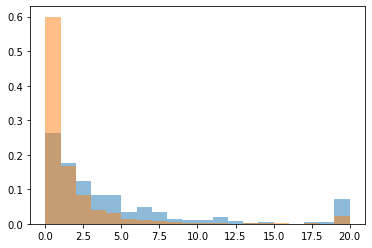

In [76]:
plt.hist(np.clip([d['num_markers_aCGH'] for d in deletions], 0, 20), alpha=0.5, bins=np.arange(0, 21, 1), density=True)
plt.hist(np.clip([d['num_markers_aCGH'] for d in sebat_deletions], 0, 20), alpha=0.5, bins=np.arange(0, 21, 1), density=True)
plt.show()

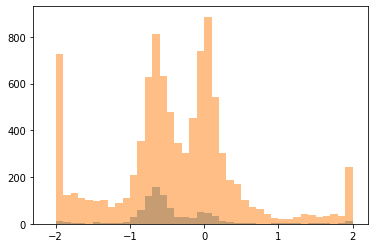

In [77]:
plt.hist(np.clip(np.log2([d['med_aCGH'] for d in deletions if ~np.isnan(d['med_aCGH'])]), -2, 2), alpha=0.5, bins=np.arange(-2.1, 2.1, 0.1))
plt.hist(np.clip(np.log2([d['med_aCGH'] for d in sebat_deletions if ~np.isnan(d['med_aCGH'])]), -2, 2), alpha=0.5, bins=np.arange(-2.1, 2.1, 0.1))
plt.show()

In [78]:
our_aCGH = np.log2([d['med_aCGH'] for d in deletions if ~np.isnan(d['med_aCGH'])])
sebat_aCGH = np.log2([d['med_aCGH'] for d in sebat_deletions if ~np.isnan(d['med_aCGH'])])
                   
    
our_aCGH_noval = np.log2([d['med_aCGH'] for d, v in zip(deletions, is_val) if ~np.isnan(d['med_aCGH']) and (not v)])
sebat_aCGH_noval = np.log2([d['med_aCGH'] for d, v in zip(sebat_deletions, sebat_is_val) if ~np.isnan(d['med_aCGH']) and (not v)])
                   

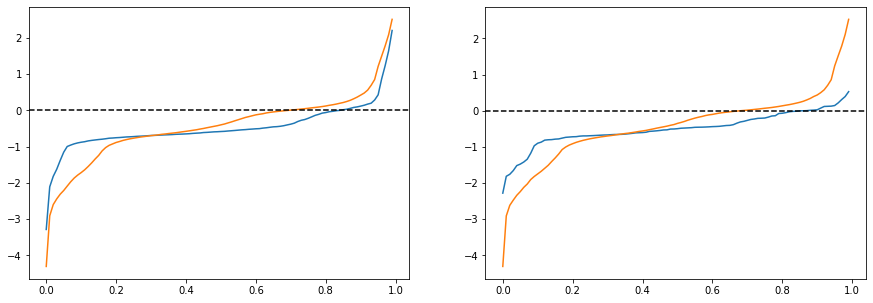

In [79]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(np.arange(0, 1, 0.01), np.quantile(our_aCGH, np.arange(0, 1, 0.01)))
plt.plot(np.arange(0, 1, 0.01), np.quantile(sebat_aCGH, np.arange(0, 1, 0.01)))
plt.axhline(0, color='black', linestyle='--')

plt.subplot(1, 2, 2)
plt.plot(np.arange(0, 1, 0.01), np.quantile(our_aCGH_noval, np.arange(0, 1, 0.01)))
plt.plot(np.arange(0, 1, 0.01), np.quantile(sebat_aCGH_noval, np.arange(0, 1, 0.01)))
plt.axhline(0, color='black', linestyle='--')

plt.show()

In [80]:
print(np.sum(our_aCGH<-0.3)/len(our_aCGH))
print(np.sum(sebat_aCGH<-0.3)/len(sebat_aCGH))

print(np.sum(our_aCGH_noval<-0.3)/len(our_aCGH_noval))
print(np.sum(sebat_aCGH_noval<-0.3)/len(sebat_aCGH_noval))

0.7224770642201835
0.5367361911749292
0.6833333333333333
0.5186324786324786


In [81]:
num_markers_ssc = np.array([d['num_markers'] for d in deletions])
num_markers_sebat = np.array([d['num_markers_ssc'] for d in sebat_deletions])
del_lengths = np.array([x['length'] for x in deletions])
sebat_del_lengths = np.array([x['length'] for x in sebat_deletions])

In [89]:
is_val_acgh = np.array([~np.isnan(d['med_aCGH']) and d['num_markers_aCGH']>2 and (np.log2(d['med_aCGH'])<-0.3) for d in deletions])
is_notval_acgh = np.array([~np.isnan(d['med_aCGH']) and d['num_markers_aCGH']>2 and (np.log2(d['med_aCGH'])>-0.3) for d in deletions])
sebat_is_val_acgh = np.array([~np.isnan(d['med_aCGH']) and d['num_markers_aCGH']>2 and (np.log2(d['med_aCGH'])<-0.3) for d in sebat_deletions])
sebat_is_notval_acgh = np.array([~np.isnan(d['med_aCGH']) and d['num_markers_aCGH']>2 and (np.log2(d['med_aCGH'])>-0.3) for d in sebat_deletions])


//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in long_scalars
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:62: RuntimeWarning: invalid value encountered in long_scalars


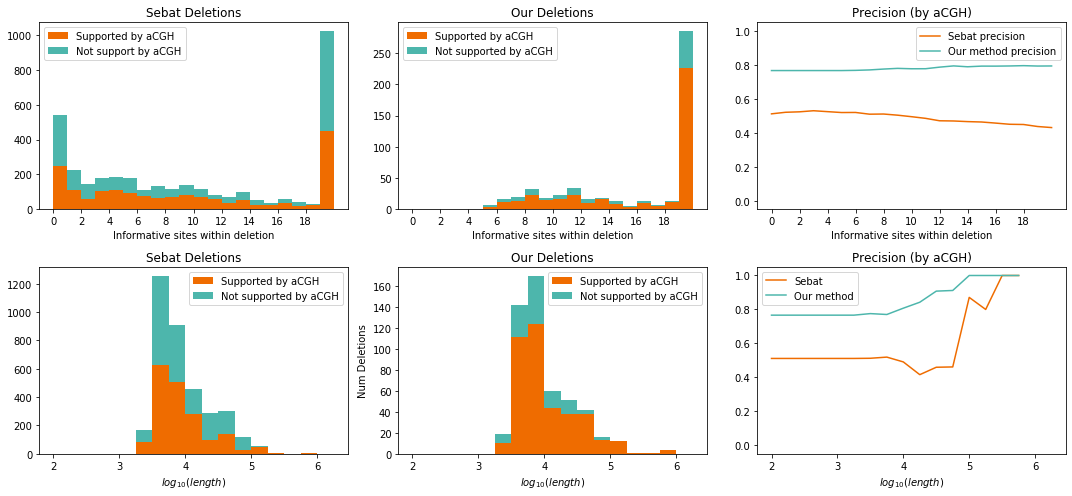

In [90]:
bins = np.arange(0, 21, 1)
plt.figure(figsize=(15, 7))
ax = plt.subplot(2, 3, 1)
plt.hist([np.clip(num_markers_sebat[sebat_is_val_acgh], 0, bins[-2]), np.clip(num_markers_sebat[sebat_is_notval_acgh], 0, bins[-2])], bins=bins, stacked=True, color=colors)
plt.xlabel('Informative sites within deletion')
plt.title('Sebat Deletions')
plt.xticks(np.arange(0, bins[-1], 2))

handles = [Rectangle((0,0),1,1, color=c, linewidth=0, ec="k") for c in colors]
labels= ["Supported by aCGH","Not support by aCGH"]
plt.legend(handles, labels)

plt.subplot(2, 3, 2, sharex=ax)
plt.hist([np.clip(num_markers_ssc[is_val_acgh], 0, bins[-2]), np.clip(num_markers_ssc[is_notval_acgh], 0, bins[-2])], bins=bins, stacked=True, color=colors)
plt.xlabel('Informative sites within deletion')
plt.title('Our Deletions')

handles = [Rectangle((0,0),1,1, color=c, linewidth=0, ec="k") for c in colors]
labels= ["Supported by aCGH","Not supported by aCGH"]
plt.legend(handles, labels)

plt.subplot(2, 3, 3, sharex=ax)
percent_val = np.zeros((len(bins),))
percent_val_ssc = np.zeros((len(bins),))
for i in range(len(bins)):
    percent_val[i] = np.sum((num_markers_sebat>=i) & sebat_is_val_acgh)/np.sum((num_markers_sebat>=i) & (sebat_is_val_acgh | sebat_is_notval_acgh))
    percent_val_ssc[i] = np.sum((num_markers_ssc>=i) & is_val_acgh)/np.sum((num_markers_ssc>=i) & (is_val_acgh | is_notval_acgh))
plt.plot(bins, percent_val, label='Sebat precision', color=colors[0])
plt.plot(bins, percent_val_ssc, label='Our method precision', color=colors[1])
plt.xlabel('Informative sites within deletion')
#plt.ylabel('Fraction of Deletions Validated')
plt.legend()
plt.title('Precision (by aCGH)')
plt.ylim([-0.05, 1.05])


bins = np.arange(2, 6.5, 0.25)
ax = plt.subplot(2, 3, 4)
chip_mark_del_n, _, _ = plt.hist([np.clip(np.log10(sebat_del_lengths)[sebat_is_val_acgh], 0, 6), np.clip(np.log10(sebat_del_lengths)[sebat_is_notval_acgh], 0, 6)], bins=bins, stacked=True, color=colors)
plt.xlabel('$log_{10}(length)$')
plt.title('Sebat Deletions')

handles = [Rectangle((0,0),1,1, color=c, linewidth=0, ec="k") for c in colors]
labels= ["Supported by aCGH","Not supported by aCGH"]
plt.legend(handles, labels)

plt.subplot(2, 3, 5, sharex=ax)
chip_mark_del_n, _, _ = plt.hist([np.clip(np.log10(del_lengths)[is_val_acgh], 0, 6), np.clip(np.log10(del_lengths)[is_notval_acgh], 0, 6)], bins=bins, stacked=True, color=colors)
plt.xlabel('$log_{10}(length)$')
plt.ylabel('Num Deletions')
plt.title('Our Deletions')

handles = [Rectangle((0,0),1,1, color=c, linewidth=0, ec="k") for c in colors]
labels= ["Supported by aCGH","Not supported by aCGH"]
plt.legend(handles, labels)

plt.subplot(2, 3, 6, sharex=ax)
percent_val = np.zeros((len(bins),))
percent_val_ssc = np.zeros((len(bins),))
for i, j in enumerate(bins):
    percent_val[i] = np.sum((np.log10(sebat_del_lengths)>=j) & sebat_is_val_acgh)/np.sum((np.log10(sebat_del_lengths)>=j) & (sebat_is_val_acgh | sebat_is_notval_acgh))
    percent_val_ssc[i] = np.sum((np.log10(del_lengths)>=j) & is_val_acgh)/np.sum((np.log10(del_lengths)>=j) & (is_val_acgh | is_notval_acgh))
plt.plot(bins, percent_val, label='Sebat', color=colors[0])
plt.plot(bins, percent_val_ssc, label='Our method', color=colors[1])
plt.xlabel('$log_{10}(length)$')
plt.legend()
plt.title('Precision (by aCGH)')
plt.ylim([-0.05, 1.05])

plt.tight_layout()
plt.show()

//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in long_scalars
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:62: RuntimeWarning: invalid value encountered in long_scalars


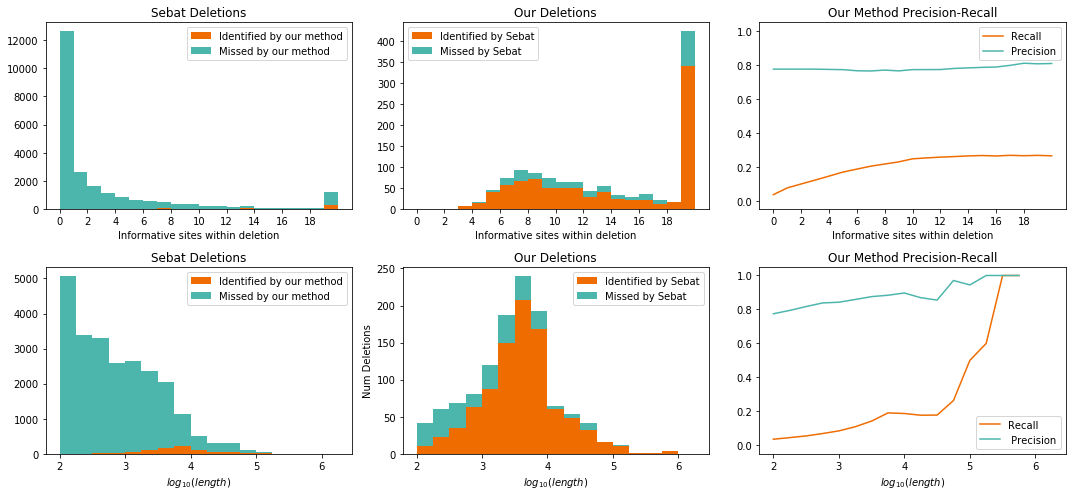

In [91]:
bins = np.arange(0, 21, 1)
plt.figure(figsize=(15, 7))
ax = plt.subplot(2, 3, 1)
plt.hist([np.clip(num_markers_sebat[sebat_is_val], 0, bins[-2]), np.clip(num_markers_sebat[~sebat_is_val], 0, bins[-2])], bins=bins, stacked=True, color=colors)
plt.xlabel('Informative sites within deletion')
plt.title('Sebat Deletions')
plt.xticks(np.arange(0, bins[-1], 2))

handles = [Rectangle((0,0),1,1, color=c, linewidth=0, ec="k") for c in colors]
labels= ["Identified by our method","Missed by our method"]
plt.legend(handles, labels)

plt.subplot(2, 3, 2, sharex=ax)
plt.hist([np.clip(num_markers_ssc[is_val], 0, bins[-2]), np.clip(num_markers_ssc[~is_val], 0, bins[-2])], bins=bins, stacked=True, color=colors)
plt.xlabel('Informative sites within deletion')
plt.title('Our Deletions')

handles = [Rectangle((0,0),1,1, color=c, linewidth=0, ec="k") for c in colors]
labels= ["Identified by Sebat","Missed by Sebat"]
plt.legend(handles, labels)

plt.subplot(2, 3, 3, sharex=ax)
percent_val = np.zeros((len(bins),))
percent_val_ssc = np.zeros((len(bins),))
for i in range(len(bins)):
    percent_val[i] = np.sum((num_markers_sebat>=i) & sebat_is_val)/np.sum((num_markers_sebat>=i))
    percent_val_ssc[i] = np.sum((num_markers_ssc>=i) & is_val)/np.sum(num_markers_ssc>=i)
plt.plot(bins, percent_val, label='Recall', color=colors[0])
plt.plot(bins, percent_val_ssc, label='Precision', color=colors[1])
plt.xlabel('Informative sites within deletion')
#plt.ylabel('Fraction of Deletions Validated')
plt.legend()
plt.title('Our Method Precision-Recall')
plt.ylim([-0.05, 1.05])


bins = np.arange(2, 6.5, 0.25)
ax = plt.subplot(2, 3, 4)
chip_mark_del_n, _, _ = plt.hist([np.clip(np.log10(sebat_del_lengths)[sebat_is_val], 0, 6), np.clip(np.log10(sebat_del_lengths)[~sebat_is_val], 0, 6)], bins=bins, stacked=True, color=colors)
plt.xlabel('$log_{10}(length)$')
plt.title('Sebat Deletions')

handles = [Rectangle((0,0),1,1, color=c, linewidth=0, ec="k") for c in colors]
labels= ["Identified by our method","Missed by our method"]
plt.legend(handles, labels)

plt.subplot(2, 3, 5, sharex=ax)
chip_mark_del_n, _, _ = plt.hist([np.clip(np.log10(del_lengths)[is_val], 0, 6), np.clip(np.log10(del_lengths)[~is_val], 0, 6)], bins=bins, stacked=True, color=colors)
plt.xlabel('$log_{10}(length)$')
plt.ylabel('Num Deletions')
plt.title('Our Deletions')

handles = [Rectangle((0,0),1,1, color=c, linewidth=0, ec="k") for c in colors]
labels= ["Identified by Sebat","Missed by Sebat"]
plt.legend(handles, labels)

plt.subplot(2, 3, 6, sharex=ax)
percent_val = np.zeros((len(bins),))
percent_val_ssc = np.zeros((len(bins),))
for i, j in enumerate(bins):
    percent_val[i] = np.sum((np.log10(sebat_del_lengths)>=j) & sebat_is_val)/np.sum((np.log10(sebat_del_lengths)>=j))
    percent_val_ssc[i] = np.sum((np.log10(del_lengths)>=j) & is_val)/np.sum(np.log10(del_lengths)>=j)
plt.plot(bins, percent_val, label='Recall', color=colors[0])
plt.plot(bins, percent_val_ssc, label=' Precision', color=colors[1])
plt.xlabel('$log_{10}(length)$')
plt.legend()
plt.title('Our Method Precision-Recall')
plt.ylim([-0.05, 1.05])

plt.tight_layout()
plt.show()